# Load dataset

In [1]:
from datasets import load_dataset

dataset = load_dataset("stsb_multi_mt", name="en")
print(dataset)

/user_data/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'similarity_score'],
        num_rows: 5749
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'similarity_score'],
        num_rows: 1379
    })
    dev: Dataset({
        features: ['sentence1', 'sentence2', 'similarity_score'],
        num_rows: 1500
    })
})


In [2]:
train_data = dataset['train']
test_data = dataset['dev']
val_data = dataset['test']
print(f'Train Size: {len(train_data)}')
print(f'Test Size: {len(test_data)}')
print(f'Val Size: {len(val_data)}')

Train Size: 5749
Test Size: 1500
Val Size: 1379


In [3]:
# Print the first sample in each dataset
print("First sample in train data:")
print(train_data[0])

print("First sample in test data:")
print(test_data[0])

print("First sample in val data:")
print(val_data[0])

First sample in train data:
{'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'similarity_score': 5.0}
First sample in test data:
{'sentence1': 'A man with a hard hat is dancing.', 'sentence2': 'A man wearing a hard hat is dancing.', 'similarity_score': 5.0}
First sample in val data:
{'sentence1': 'A girl is styling her hair.', 'sentence2': 'A girl is brushing her hair.', 'similarity_score': 2.5}


# Load model

In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize tokenizer and model (BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to(device)

/usr/local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define dataset

In [5]:
import torch
from torch.utils.data import Dataset

class SentenceSimilarityDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pair = self.data[idx]

        encoded_pair = self.tokenizer(
            pair['sentence1'],
            pair['sentence2'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = encoded_pair['input_ids'].squeeze(0)
        attention_mask = encoded_pair['attention_mask'].squeeze(0)
        label = torch.tensor([pair['similarity_score']], dtype=torch.float32)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }

In [6]:
train_dataset = SentenceSimilarityDataset(train_data, tokenizer)
test_dataset = SentenceSimilarityDataset(test_data, tokenizer)
val_dataset = SentenceSimilarityDataset(val_data, tokenizer)

In [7]:
sample_train = train_dataset[0]

print(f"Train Sample: {train_data[0]}")

print(f"input_ids: \n{sample_train['input_ids']}")
print(f"Type of input_ids: {type(sample_train['input_ids'])}")
print(f"input_ids size: {sample_train['input_ids'].size()}")

print(f"attention_mask: \n{sample_train['attention_mask']}")
print(f"Type of attention_mask: {type(sample_train['attention_mask'])}")
print(f"attention_mask size: {sample_train['attention_mask'].size()}")

print(f"label: \n{sample_train['label']}")
print(f"Type of label: {type(sample_train['label'])}")
print(f"label size: {sample_train['label'].size()}")

Train Sample: {'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'similarity_score': 5.0}
input_ids: 
tensor([ 101, 1037, 4946, 2003, 2635, 2125, 1012,  102, 2019, 2250, 4946, 2003,
        2635, 2125, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
Type of 

# Trainer

In [8]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.squeeze() if isinstance(pred.predictions, tuple) else pred.predictions
    mse = mean_squared_error(labels, preds)
    rmse = mean_squared_error(labels, preds, squared=False)
    mae = mean_absolute_error(labels, preds)
    
    return {"mse": mse, "rmse": rmse, "mae": mae}

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./bert_model',        # 訓練模型的目錄
    num_train_epochs=10,              # 訓練的 epoch 數
    per_device_train_batch_size=4,    # 訓練時的 batch size
    per_device_eval_batch_size=4,     # 驗證時的 batch size
    gradient_accumulation_steps=2,    # 梯度累積的步數
    eval_accumulation_steps=2,        # 每幾步把eval_dataset從顯卡丟到cpu
    warmup_steps=500,                 # 學習率 warmup 步驟
    weight_decay=0.01,                # 權重衰減
    logging_dir='./bert_logs',        # 訓練 log 的目錄
    logging_steps=250,
    evaluation_strategy='epoch',
    save_total_limit=5,
    push_to_hub=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

# Save the model and tokenizer
model.save_pretrained("./bert_model_trained")
tokenizer.save_pretrained("./bert_tokenizer") 

2023-12-11 00:43:56.701021: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 00:43:56.719321: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 00:43:56.719342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 00:43:56.719355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 00:43:56.723454: I tensorflow/core/platform/cpu_feature_g

Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae
1,0.960600,1.186846,1.186846,1.089424,0.855157
2,0.482600,0.808308,0.808308,0.899059,0.673219
3,0.303800,0.768058,0.768058,0.876389,0.652573
4,0.209100,0.742808,0.742808,0.861863,0.636840
5,0.138200,0.767074,0.767074,0.875828,0.671874
6,0.112800,0.720292,0.720292,0.848700,0.639809
7,0.080800,0.693872,0.693872,0.832990,0.627157
8,0.059800,0.710489,0.710489,0.842905,0.627168
9,0.045700,0.712783,0.712783,0.844265,0.633795
10,0.031500,0.705735,0.705735,0.840080,0.626859


('./bert_tokenizer/tokenizer_config.json',
 './bert_tokenizer/special_tokens_map.json',
 './bert_tokenizer/vocab.txt',
 './bert_tokenizer/added_tokens.json')

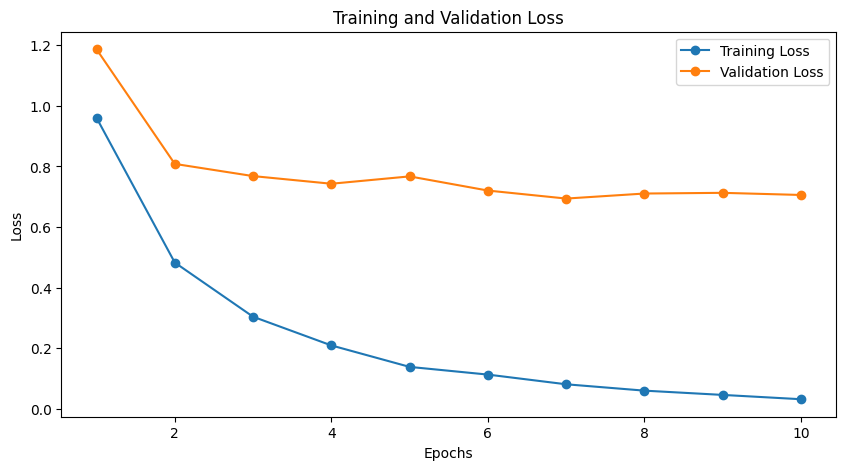

In [20]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
training_loss = [0.9606, 0.4826, 0.3038, 0.2091, 0.1382, 0.1128, 0.0808, 0.0598, 0.0457, 0.0315]  
validation_loss = [1.186846, 0.808308, 0.768058, 0.742808, 0.767074, 0.720292, 0.693872, 0.710489, 0.712783, 0.705735] 

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


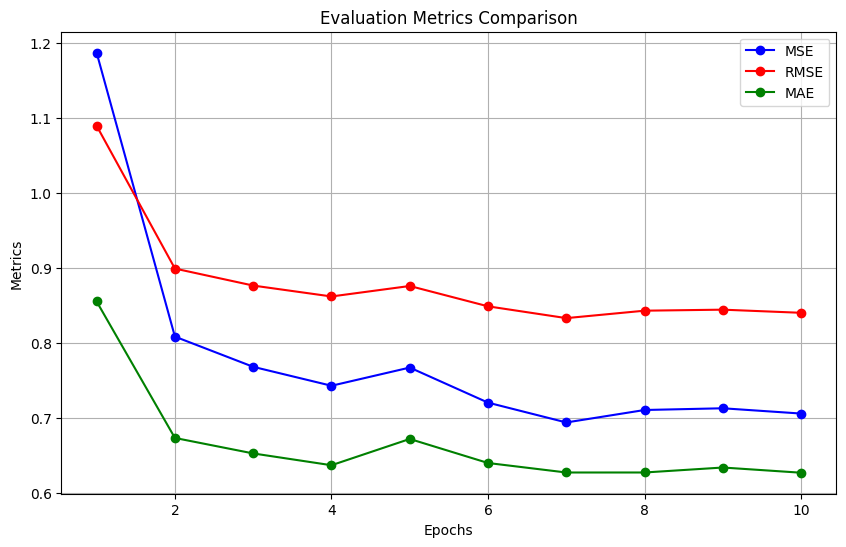

In [21]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))  
mse = [1.186846, 0.808308, 0.768058, 0.742808, 0.767074, 0.720292, 0.693872, 0.710489, 0.712783, 0.705735]  
rmse = [1.089424, 0.899059, 0.876389, 0.861863, 0.875828, 0.848700, 0.832990, 0.842905, 0.844265, 0.840080]  
mae = [0.855157, 0.673219, 0.652573, 0.636840, 0.671874, 0.639809, 0.627157, 0.627168, 0.633795, 0.626859]  

plt.figure(figsize=(10, 6))
plt.plot(epochs, mse, label='MSE', marker='o', color='blue')
plt.plot(epochs, rmse, label='RMSE', marker='o', color='red')
plt.plot(epochs, mae, label='MAE', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Evaluation Metrics Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.5254254341125488, 'eval_mse': 0.5254254341125488, 'eval_rmse': 0.7248623371124268, 'eval_mae': 0.5499489903450012, 'eval_runtime': 59.5534, 'eval_samples_per_second': 25.187, 'eval_steps_per_second': 6.297, 'epoch': 10.0}


Evaluation Results: {
    'eval_loss': 0.5254254341125488, 
    'eval_mse': 0.5254254341125488, 
    'eval_rmse': 0.7248623371124268, 
    'eval_mae': 0.5499489903450012, 
    'eval_runtime': 59.5534, 
    'eval_samples_per_second': 25.187, 
    'eval_steps_per_second': 6.297, 
    'epoch': 10.0
    }

# inference

In [12]:
model = BertForSequenceClassification.from_pretrained("./bert_model/checkpoint-7000")
tokenizer = BertTokenizer.from_pretrained("./bert_tokenizer")

def sentence_similarity(sentence1, sentence2):
    encoded_input = tokenizer(sentence1, sentence2, return_tensors='pt')

    with torch.no_grad():
        model_output = model(**encoded_input)

    similarity_score = model_output.logits.item()

    return similarity_score

In [13]:
val_data[0]

{'sentence1': 'A girl is styling her hair.',
 'sentence2': 'A girl is brushing her hair.',
 'similarity_score': 2.5}

In [14]:
predicted_scores = []
true_scores = []

for idx, sample in enumerate(val_data):
    sentence1 = sample['sentence1']
    sentence2 = sample['sentence2']
    similarity_score = sentence_similarity(sentence1, sentence2)

    predicted_scores.append(similarity_score)
    true_scores.append(sample['similarity_score'])

    score_difference = abs(similarity_score - sample['similarity_score'])

    print("Sample Index:", idx)
    print("Sentence 1:", sentence1)
    print("Sentence 2:", sentence2)
    print("Predicted Similarity Score:", similarity_score)
    print("True Similarity Score:", sample['similarity_score'])
    print("Score Difference:", score_difference)
    print()

Sample Index: 0
Sentence 1: A girl is styling her hair.
Sentence 2: A girl is brushing her hair.
Predicted Similarity Score: 3.6327767372131348
True Similarity Score: 2.5
Score Difference: 1.1327767372131348

Sample Index: 1
Sentence 1: A group of men play soccer on the beach.
Sentence 2: A group of boys are playing soccer on the beach.
Predicted Similarity Score: 4.16187047958374
True Similarity Score: 3.5999999046325684
Score Difference: 0.5618705749511719

Sample Index: 2
Sentence 1: One woman is measuring another woman's ankle.
Sentence 2: A woman measures another woman's ankle.
Predicted Similarity Score: 4.859770774841309
True Similarity Score: 5.0
Score Difference: 0.1402292251586914

Sample Index: 3
Sentence 1: A man is cutting up a cucumber.
Sentence 2: A man is slicing a cucumber.
Predicted Similarity Score: 4.892926216125488
True Similarity Score: 4.199999809265137
Score Difference: 0.6929264068603516

Sample Index: 4
Sentence 1: A man is playing a harp.
Sentence 2: A man is

In [16]:
while True:
    try:
        index = int(input("Enter the sample index (0 to exit): "))
        if index == 0:
            break
        print("Sample Index:", index)
        print("Sentnece 1:", val_data[index]['sentence1'])
        print("Sentnece 2:", val_data[index]['sentence2'])
        print("Predicted Similarity Score:", predicted_scores[index])
        print("True Similarity Score:", true_scores[index])
        print()
    except ValueError:
        print("Please enter a valid index (integer).")

Sample Index: 56
Sentnece 1: A man puts three pieces of meat into a pan.
Sentnece 2: A man is putting meat in a pan.
Predicted Similarity Score: 3.5298964977264404
True Similarity Score: 4.0

Sample Index: 345
Sentnece 1: A man and woman are posing for the camera.
Sentnece 2: A cat sitting on sand looking up at the camera.
Predicted Similarity Score: 0.9991670250892639
True Similarity Score: 1.399999976158142

Sample Index: 756
Sentnece 1: There's not a lot you can do about that.
Sentnece 2: I really do not think there is much you can do about that.
Predicted Similarity Score: 1.9236456155776978
True Similarity Score: 5.0

Sample Index: 1000
Sentnece 1: Miodrag Zivkovic, of the Liberal Alliance of Montenegro, won 31 percent of the vote while the independent Dragan Hajdukovic got four percent.
Sentnece 2: Miodrag Zivkovic, the leader of the pro-independence opposition Liberal Alliance, came in second with 31 percent of the vote.
Predicted Similarity Score: 3.1226913928985596
True Simila

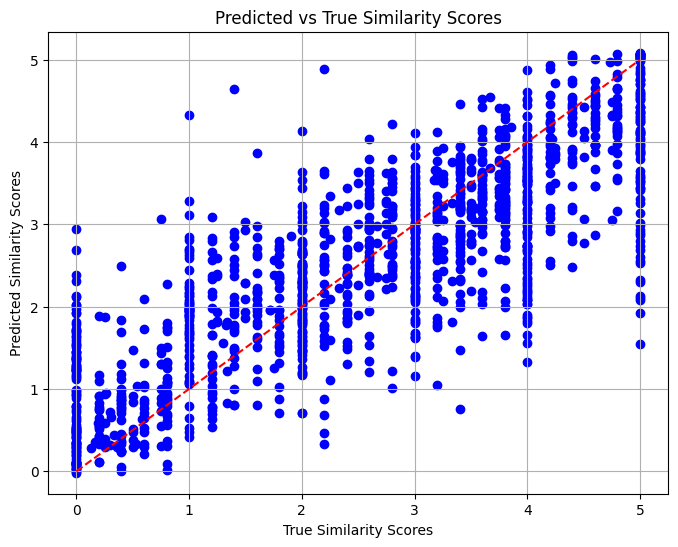

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(true_scores, predicted_scores, color='blue')
plt.plot([min(true_scores), max(true_scores)], [min(true_scores), max(true_scores)], color='red', linestyle='--')
plt.title('Predicted vs True Similarity Scores')
plt.xlabel('True Similarity Scores')
plt.ylabel('Predicted Similarity Scores')
plt.grid(True)
plt.show()
